# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py

In [6]:
from __future__ import division, print_function, absolute_import
%pylab inline

import tensorflow as tf
import numpy as np
import os
import librosa
import librosa.display
from  librosa.util import frame
from scipy.signal import resample

%run ../utils.py
%run nnutils.py

rc_default()

SAVEFIG = False

Populating the interactive namespace from numpy and matplotlib


In [3]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'
fname = 'Grisey_partiels.wav'
fname = 'Xenakis_Metastasis.wav'
fname = 'battles_atlas.wav'

name = fname[:-4]

filename = path+fname

fs,track = fragment_from_wav(filename,100,160)

track = resample(track,int(track.size/2.0))
fs = fs/2.0


NFFT = 2**11
HOP = int(NFFT/4)

STFT = librosa.stft(track,n_fft=NFFT, hop_length=HOP,center=True).T
mel = librosa.feature.melspectrogram(S=abs(STFT)**2).T

X = abs(STFT/float(NFFT)/2)**2

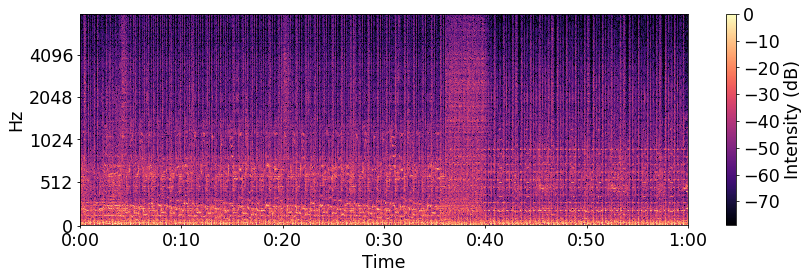

In [7]:
figure(figsize=(14,4))
librosa.display.specshow(librosa.logamplitude(X.T,ref_power=np.max),hop_length = HOP, sr=fs,y_axis='mel', fmax=8000, x_axis='time')
colorbar(label='Intensity (dB)');

In [5]:
print("Dimensions: freq bins, time bins")
time_bins,freq_bins = X.shape
print(freq_bins,time_bins)

Dimensions: freq bins, time bins
1025 6891


## Create dataset  (Data class) with spectrum

In [6]:
Xlog = log10(X)
meanX = Xlog.mean(0)
stdX = Xlog.std(0)+0.001
Xnorm = (Xlog-meanX)/stdX
data = Data( Xnorm )

## Neural Autoencoder parameters

In [7]:
display_step = 10
batch_size = 2000
n_epochs = 500
learning_rate = 0.002
dimensions= [768,512,256,128,64,32,16,8]

In [8]:
nae = NAE(freq_bins,dimensions,activation=tf.nn.tanh,bias=True,learning_rate=learning_rate,stddev=0.1,reg_constant=0.01*0,meaninit=.00,identity=False)
nae.init_session()


[1025, 768]
[768, 512]
[512, 256]
[256, 128]
[128, 64]
[64, 32]
[32, 16]
[16, 8]
[16, 32, 64, 128, 256, 512, 768, 8]
[8, 16]
[16, 32]
[32, 64]
[64, 128]
[128, 256]
[256, 512]
[512, 768]
[768, 8]


In [9]:
costlist = nae.train(data, batch_size, n_epochs)

Epoch: 0000 cost= 0.728761911
Epoch: 0010 cost= 0.447308123
Epoch: 0020 cost= 0.429693848
Epoch: 0030 cost= 0.425638586
Epoch: 0040 cost= 0.411764950
Epoch: 0050 cost= 0.401732802
Epoch: 0060 cost= 0.393891305
Epoch: 0070 cost= 0.383840799
Epoch: 0080 cost= 0.378675044
Epoch: 0090 cost= 0.374734819
Epoch: 0100 cost= 0.377573073
Epoch: 0110 cost= 0.378014326
Epoch: 0120 cost= 0.367654830
Epoch: 0130 cost= 0.373481393
Epoch: 0140 cost= 0.361388147
Epoch: 0150 cost= 0.370965183
Epoch: 0160 cost= 0.361237019
Epoch: 0170 cost= 0.361686766
Epoch: 0180 cost= 0.360257298
Epoch: 0190 cost= 0.358908296
Epoch: 0200 cost= 0.348421365
Epoch: 0210 cost= 0.348940551
Epoch: 0220 cost= 0.343018949
Epoch: 0230 cost= 0.342837512
Epoch: 0240 cost= 0.336685568
Epoch: 0250 cost= 0.337059379
Epoch: 0260 cost= 0.333429039
Epoch: 0270 cost= 0.330467254
Epoch: 0280 cost= 0.325279951
Epoch: 0290 cost= 0.328575671
Epoch: 0300 cost= 0.327127516
Epoch: 0310 cost= 0.325507611
Epoch: 0320 cost= 0.315385967
Epoch: 033

In [10]:
nae.save("checkpoints/NAE8")

Model saved in file: checkpoints/NAE8.ckpt


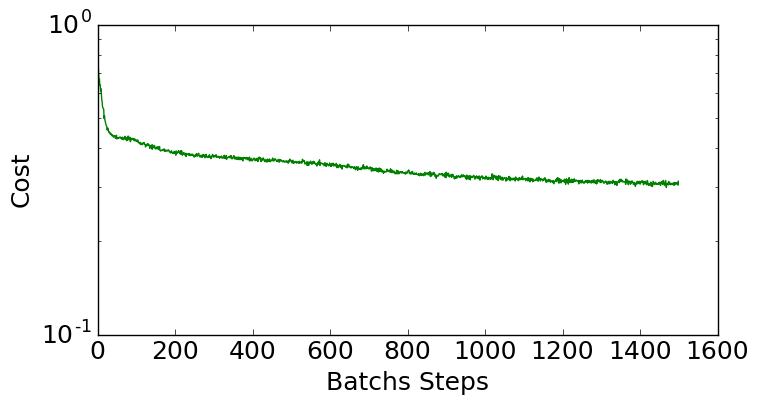

In [11]:
figure(figsize=(8,4))
semilogy(costlist,'g')
ylabel('Cost')
xlabel('Batchs Steps');

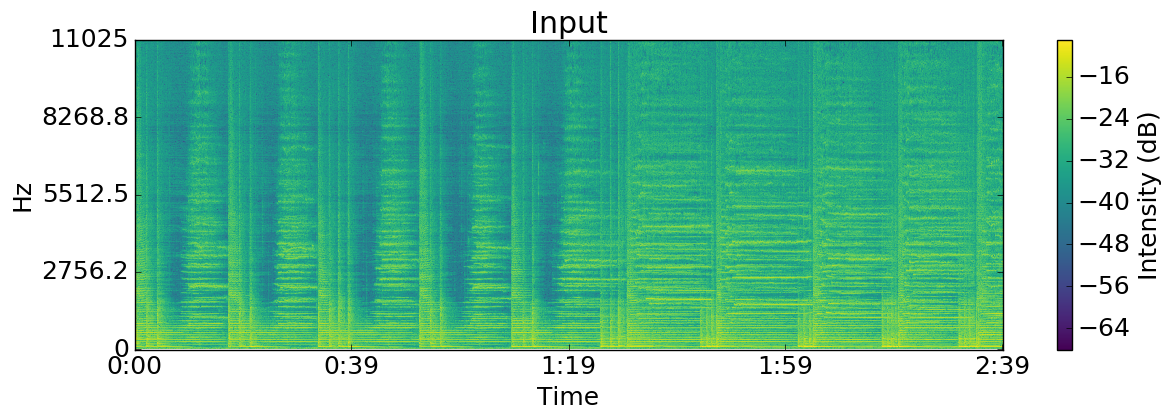

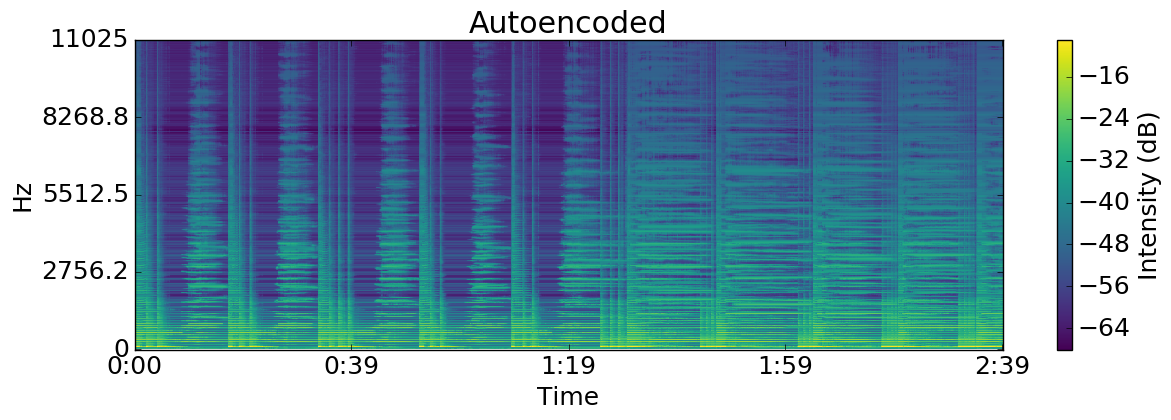

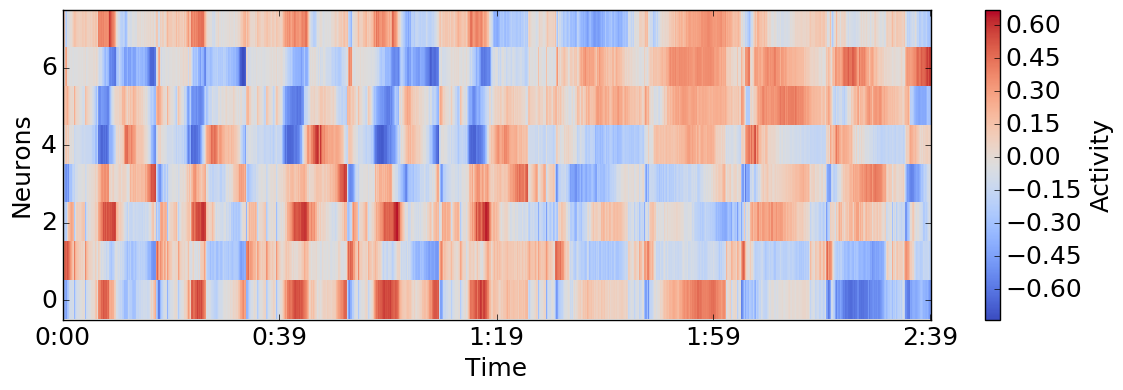

In [12]:
sess = nae.get_session()
variable_dict = nae.get_variables_dict()

SAVEFIG = False

duration = track.size/fs
compare = range(0,time_bins,1)
recon = sess.run(variable_dict['Y'], feed_dict={ variable_dict['X']: data.data[compare]})

orig = data.data[compare]
M1 = orig*stdX+meanX

figure(figsize=(14,4))

# librosa.display.specshow(librosa.logamplitude(M.T,ref_power=np.max),hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time')
librosa.display.specshow(3.*M1.T,hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time',cmap = cm.viridis)
# imshow((M1.T),aspect='auto',interpolation='none',origin='bottom')

title('Input')
colorbar(label='Intensity (dB)')
if SAVEFIG:plt.savefig('../../talk/figs/Autoencoder/original')

Y = recon*stdX+meanX
M = (Y-Y.min())/(Y.max()-Y.min())*(M1.max()-M1.min())+M1.min()

figure(figsize=(14,4))

# librosa.display.specshow(librosa.logamplitude(M.T,ref_power=np.max),hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time')
librosa.display.specshow(3.*M.T,hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time',cmap = cm.viridis)

# imshow((M.T),aspect='auto',interpolation='none',origin='bottom')

title('Autoencoded');
colorbar(label='Intensity (dB)');
if SAVEFIG: plt.savefig('../../talk/figs/Autoencoder/ae')
    
figure(figsize=(14,4))
Z = sess.run(variable_dict['z'], feed_dict={ variable_dict['X']: data.data[compare]})
idx = np.lexsort(Z)
librosa.display.specshow(Z.T,hop_length = HOP,sr=fs, x_axis='time')
yticks(range(0,Z[0].size,2))
ylabel('Neurons')
colorbar(label='Activity')
if SAVEFIG: plt.savefig('../../talk/figs/Autoencoder/Z')